# Dealing with Low Confidence Situations

First we analyze a few scenarios where spurious examines or clicks result in inaccurate relevance grades. We then augment the SDBN judgments with a beta prior to better model the amount of confidence we have in the underlying click data.

In [2]:
import sys
sys.path.append('..')
from aips import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from session_gen import SessionGenerator

# if using a Jupyter notebook, includue:
%matplotlib inline

In [3]:
sessions = all_sessions()
sessions

sess_id   query  rank        doc_id  clicked
0             2    ipad   0.0   92636260712    False
1             2    ipad   1.0  635753493559     True
2             2    ipad   2.0  885909393404    False
3             2    ipad   3.0  843404073153    False
4             2    ipad   4.0  885909457595    False
...         ...     ...   ...           ...      ...
149995    60001  bluray  25.0   23942973416    False
149996    60001  bluray  26.0   25192107191    False
149997    60001  bluray  27.0   27242809710    False
149998    60001  bluray  28.0  600603132872    False
149999    60001  bluray  29.0  600603141003    False

[1775000 rows x 5 columns]

In [4]:
products = fetch_products(doc_ids=sessions['doc_id'].unique())
products

image            upc  \
0    <img height="100" src="../data/retrotech/image...   885909472376   
1    <img height="100" src="../data/retrotech/image...   814916010240   
2    <img height="100" src="../data/retrotech/image...  9781400532629   
3    <img height="100" src="../data/retrotech/image...   685387305636   
4    <img height="100" src="../data/retrotech/image...    27242708242   
..                                                 ...            ...   
306  <img height="100" src="../data/retrotech/image...    97361301747   
307  <img height="100" src="../data/retrotech/image...    25192073007   
308  <img height="100" src="../data/retrotech/image...    25192073007   
309  <img height="100" src="../data/retrotech/image...    30206696622   
310  <img height="100" src="../data/retrotech/image...    30206696622   

                                                  name  \
0    Apple&#xAE; - iPad&#xAE; 2 with Wi-Fi - 32GB -...   
1                        Amazon - Kindle DX - Graphite   
2     Barnes & Noble - NOOK WiFi eReader - White/White   
3    Griffin Technology - PowerBlock Micro Charger ...   
4    Sony - 900MHz Analog RF Wireless Headphones - ...   
..                                                 ...   
306                   Star Trek: Fan Collectives - DVD   
307  Blues Brothers (Rated) (Unrated) - Widescreen ...   
308  The Blues Brothers - Widescreen Dubbed Subtitl...   
309       Star Trek (Score) - Original Soundtrack - CD   
310  Star Trek [Music from the Motion Picture] - Or...   

                    manufacturer  \
0                    Apple&#xAE;   
1                         Amazon   
2                 Barnes & Noble   
3             Griffin Technology   
4                           Sony   
..                           ...   
306                           \N   
307                           \N   
308                           \N   
309  Var&#xBF;se Sarabande (USA)   
310  Var&#xBF;se Sarabande (USA)   

                                      shortDescription  \
0    9.7" widescreen display; 802.11a/b/g/n Wi-Fi; ...   
1    9.7" display with E-Ink technology; supports P...   
2    6" eInk display; supports PDF, ePub, JPEG, PNG...   
3    Compatible with select iPod and iPhone models;...   
4    FM stereo sound; induction charging; compatibl...   
..                                                 ...   
306                                                 \N   
307                                                 \N   
308                                                 \N   
309                                                 \N   
310                                                 \N   

                                       longDescription  \
0    The all-new thinner and lighter design makes i...   
1    Store up to 3,500 eBooks on this Kindle digita...   
2    This reader's built-in Wi-Fi wireless networki...   
3    Keep your iPhone or iPod charged and ready for...   
4    Listen to your favorite music without worrying...   
..                                                 ...   
306                                                 \N   
307                                                 \N   
308                                                 \N   
309                                                 \N   
310                                                 \N   

                                       id            _version_  
0    ec31addc-241a-4266-9d22-1da243559a92  1787806796394528770  
1    e7994184-e31f-42ab-ba65-cc3023eb29bf  1787806796409208834  
2    2791c987-912b-4e2b-b254-ec986f91b27e  1787806796441714691  
3    c43ad77d-c240-4a4d-b629-a6833aa1a08c  1787806796608438274  
4    bf1f0573-6962-43c6-ad5d-5e272dfab677  1787806796634652690  
..                                    ...                  ...  
306  2d24ae31-f290-4b2d-b930-995fe83a51bf  1787806797059325953  
307  401ea3a8-7307-4dc0-a617-da4d99806ed9  1787806797068763168  
308  de4d06b3-91c0-47c1-b1aa-69f7bf5888f5  1787806797077151746 

## Listing 11.10

Computing SDBN judgments on transformers dark of the moon

In [22]:
def sdbn_statistics(sdbn_session):
    last_click_per_session = sdbn_session.groupby(['clicked', 'sess_id'])['rank'].max()[True]
    sdbn_session['last_click_rank'] = last_click_per_session
    sdbn_session['examined'] = sdbn_session['rank'] <= sdbn_session['last_click_rank']
    sdbn = sdbn_session[sdbn_session['examined']].groupby('doc_id')[['clicked', 'examined']].sum()
    sdbn['grade'] = sdbn['clicked'] / sdbn['examined']

    return sdbn.sort_values('grade', ascending=False)

In [23]:
query = "transformers dark of the moon"
sdbn_sess = sessions[sessions['query'] == query].copy().set_index('sess_id')
sdbn = sdbn_statistics(sdbn_sess)
sdbn

clicked  examined     grade
doc_id                                   
97360810042       412       642  0.641745
400192926087       62       129  0.480620
97363560449        96       243  0.395062
97363532149        42       130  0.323077
93624956037        41       154  0.266234
47875842328       367      1531  0.239713
47875841420       217       960  0.226042
25192107191       176      1082  0.162662
786936817218      118       777  0.151866
36725235564        41       277  0.148014
24543701538       182      1232  0.147727
47875841369        37       251  0.147410
47875841406        80       626  0.127796
24543750949        31       313  0.099042
47875842335        53       681  0.077827

## Listing 11.11

Computing relevance judgments for `blue ray` a simulated tail query that represents a misspelling with sparse data.

In [25]:
query = "blue ray"
# Simulate a rare query by slicing out some data
sdbn_sessions = sessions[sessions['query'] == query]
sdbn_sessions = sdbn_sessions[sdbn_sessions['sess_id'] < 50050]
sdbn_sessions = sdbn_sessions.set_index('sess_id')
sdbn = sdbn_statistics(sdbn_sessions)
sdbn

clicked  examined     grade
doc_id                                   
600603132872        1         1  1.000000
827396513927       14        34  0.411765
25192073007         8        20  0.400000
885170033412        6        19  0.315789
600603141003        8        26  0.307692
24543672067         8        27  0.296296
813774010904        2         7  0.285714
883929140855        2         7  0.285714
22265052211         1         4  0.250000
786936817232        2         8  0.250000
883929197965        2         9  0.222222
719192580374        4        18  0.222222
711719983156        2        10  0.200000
36725608443         1         6  0.166667
36725617605         1         8  0.125000
826663129342        1         9  0.111111
36725608894         1        10  0.100000
711719804604        1        10  0.100000
75993997675         1        11  0.090909
786936817218        1        14  0.071429
22265004517         1        14  0.071429
786936805017        1        14  0.071429
58231306590         0         7  0.000000
58231300826         0         8  0.000000
36725608511         0        11  0.000000
27242809710         0         6  0.000000
25192107191         0         7  0.000000
23942972389         0        15  0.000000
885170038875        0         5  0.000000

# Figure 11.9

Beta distribution for grade=0.125

a=2.5 b=17.5


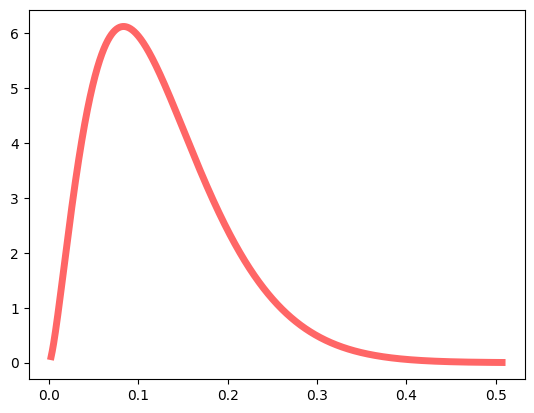

In [27]:
from scipy.stats import beta

prior_grade = 0.125
prior_weight = 20
a = prior_grade * prior_weight; b = (1 - prior_grade) * prior_weight
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)
ax.plot(x, beta.pdf(x, a, b), 'r-', lw=5, alpha=0.6, label='beta pdf')

# Figure 11.10

Adding clicks to the beta distribution

a=3.5 b=17.5


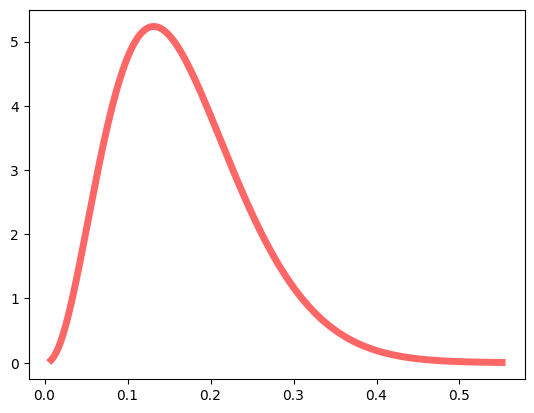

In [28]:
# Fit a beta prior to global_ctr
a += 1
print(f"a={a} b={b}")

x = np.linspace(beta.ppf(0.0001, a, b), beta.ppf(0.9999, a, b), 10000)
fig, ax = plt.subplots(1, 1)

ax.plot(x, beta.pdf(x, a, b),
        'r-', lw=5, alpha=0.6, label='beta pdf')

## Listing 11.12

Starting with a prior beta distribution for each document for "blue ray"

In [29]:
prior_grade = 0.3
prior_weight = 100
sdbn['prior_a'] = prior_grade * prior_weight
sdbn['prior_b'] = (1 - prior_grade)* prior_weight

sdbn

clicked  examined     grade  prior_a  prior_b
doc_id                                                     
600603132872        1         1  1.000000     30.0     70.0
827396513927       14        34  0.411765     30.0     70.0
25192073007         8        20  0.400000     30.0     70.0
885170033412        6        19  0.315789     30.0     70.0
600603141003        8        26  0.307692     30.0     70.0
24543672067         8        27  0.296296     30.0     70.0
813774010904        2         7  0.285714     30.0     70.0
883929140855        2         7  0.285714     30.0     70.0
22265052211         1         4  0.250000     30.0     70.0
786936817232        2         8  0.250000     30.0     70.0
883929197965        2         9  0.222222     30.0     70.0
719192580374        4        18  0.222222     30.0     70.0
711719983156        2        10  0.200000     30.0     70.0
36725608443         1         6  0.166667     30.0     70.0
36725617605         1         8  0.125000     30.0     70.0
826663129342        1         9  0.111111     30.0     70.0
36725608894         1        10  0.100000     30.0     70.0
711719804604        1        10  0.100000     30.0     70.0
75993997675         1        11  0.090909     30.0     70.0
786936817218        1        14  0.071429     30.0     70.0
22265004517         1        14  0.071429     30.0     70.0
786936805017        1        14  0.071429     30.0     70.0
58231306590         0         7  0.000000     30.0     70.0
58231300826         0         8  0.000000     30.0     70.0
36725608511         0        11  0.000000     30.0     70.0
27242809710         0         6  0.000000     30.0     70.0
25192107191         0         7  0.000000     30.0     70.0
23942972389         0        15  0.000000     30.0     70.0
885170038875        0         5  0.000000     30.0     70.0

## Listing 11.13

Here we update the beta posterior to account for the observations in our data. We then compute a new grade, `beta-grade` from the posterior distribution.

In [30]:
sdbn['posterior_a'] = sdbn['prior_a'] + sdbn['clicked']
sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])
sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])
sdbn.sort_values('beta_grade', ascending=False)

clicked  examined     grade  prior_a  prior_b  posterior_a  \
doc_id                                                                     
827396513927       14        34  0.411765     30.0     70.0         44.0   
25192073007         8        20  0.400000     30.0     70.0         38.0   
600603132872        1         1  1.000000     30.0     70.0         31.0   
885170033412        6        19  0.315789     30.0     70.0         36.0   
600603141003        8        26  0.307692     30.0     70.0         38.0   
24543672067         8        27  0.296296     30.0     70.0         38.0   
813774010904        2         7  0.285714     30.0     70.0         32.0   
883929140855        2         7  0.285714     30.0     70.0         32.0   
22265052211         1         4  0.250000     30.0     70.0         31.0   
786936817232        2         8  0.250000     30.0     70.0         32.0   
883929197965        2         9  0.222222     30.0     70.0         32.0   
36725608443         1         6  0.166667     30.0     70.0         31.0   
711719983156        2        10  0.200000     30.0     70.0         32.0   
719192580374        4        18  0.222222     30.0     70.0         34.0   
36725617605         1         8  0.125000     30.0     70.0         31.0   
885170038875        0         5  0.000000     30.0     70.0         30.0   
826663129342        1         9  0.111111     30.0     70.0         31.0   
27242809710         0         6  0.000000     30.0     70.0         30.0   
36725608894         1        10  0.100000     30.0     70.0         31.0   
711719804604        1        10  0.100000     30.0     70.0         31.0   
58231306590         0         7  0.000000     30.0     70.0         30.0   
25192107191         0         7  0.000000     30.0     70.0         30.0   
75993997675         1        11  0.090909     30.0     70.0         31.0   
58231300826         0         8  0.000000     30.0     70.0         30.0   
786936817218        1        14  0.071429     30.0     70.0         31.0   
22265004517         1        14  0.071429     30.0     70.0         31.0   
786936805017        1        14  0.071429     30.0     70.0         31.0   
36725608511         0        11  0.000000     30.0     70.0         30.0   
23942972389         0        15  0.000000     30.0     70.0         30.0   

              posterior_b  beta_grade  
doc_id                                 
827396513927         90.0    0.328358  
25192073007          82.0    0.316667  
600603132872         70.0    0.306931  
885170033412         83.0    0.302521  
600603141003         88.0    0.301587  
24543672067          89.0    0.299213  
813774010904         75.0    0.299065  
883929140855         75.0    0.299065  
22265052211          73.0    0.298077  
786936817232         76.0    0.296296  
883929197965         77.0    0.293578  
36725608443          75.0    0.292453  
711719983156         78.0    0.290909  
719192580374         84.0    0.288136  
36725617605          77.0    0.287037  
885170038875         75.0    0.285714  
826663129342         78.0    0.284404  
27242809710          76.0    0.283019  
36725608894          79.0    0.281818  
711719804604         79.0    0.281818  
58231306590          77.0    0.280374  
25192107191          77.0    0.280374  
75993997675          80.0    0.279279  
58231300826          78.0    0.277778  
786936817218         83.0    0.271930  
22265004517          83.0    0.271930  
786936805017         83.0    0.271930  
36725608511          81.0    0.270270  
23942972389          85.0    0.260870

In [11]:
sdbn = sdbn.sort_values('beta_grade', ascending=False).reset_index()
sdbn

doc_id  clicked  examined     grade  prior_a  prior_b  posterior_a  \
0   827396513927       14        34  0.411765     30.0     70.0         44.0   
1    25192073007        8        20  0.400000     30.0     70.0         38.0   
2   600603132872        1         1  1.000000     30.0     70.0         31.0   
3   885170033412        6        19  0.315789     30.0     70.0         36.0   
4   600603141003        8        26  0.307692     30.0     70.0         38.0   
5    24543672067        8        27  0.296296     30.0     70.0         38.0   
6   813774010904        2         7  0.285714     30.0     70.0         32.0   
7   883929140855        2         7  0.285714     30.0     70.0         32.0   
8    22265052211        1         4  0.250000     30.0     70.0         31.0   
9   786936817232        2         8  0.250000     30.0     70.0         32.0   
10  883929197965        2         9  0.222222     30.0     70.0         32.0   
11   36725608443        1         6  0.166667     30.0     70.0         31.0   
12  711719983156        2        10  0.200000     30.0     70.0         32.0   
13  719192580374        4        18  0.222222     30.0     70.0         34.0   
14   36725617605        1         8  0.125000     30.0     70.0         31.0   
15  885170038875        0         5  0.000000     30.0     70.0         30.0   
16  826663129342        1         9  0.111111     30.0     70.0         31.0   
17   27242809710        0         6  0.000000     30.0     70.0         30.0   
18   36725608894        1        10  0.100000     30.0     70.0         31.0   
19  711719804604        1        10  0.100000     30.0     70.0         31.0   
20   58231306590        0         7  0.000000     30.0     70.0         30.0   
21   25192107191        0         7  0.000000     30.0     70.0         30.0   
22   75993997675        1        11  0.090909     30.0     70.0         31.0   
23   58231300826        0         8  0.000000     30.0     70.0         30.0   
24  786936817218        1        14  0.071429     30.0     70.0         31.0   
25   22265004517        1        14  0.071429     30.0     70.0         31.0   
26  786936805017        1        14  0.071429     30.0     70.0         31.0   
27   36725608511        0        11  0.000000     30.0     70.0         30.0   
28   23942972389        0        15  0.000000     30.0     70.0         30.0   

    posterior_b  beta_grade  
0          90.0    0.328358  
1          82.0    0.316667  
2          70.0    0.306931  
3          83.0    0.302521  
4          88.0    0.301587  
5          89.0    0.299213  
6          75.0    0.299065  
7          75.0    0.299065  
8          73.0    0.298077  
9          76.0    0.296296  
10         77.0    0.293578  
11         75.0    0.292453  
12         78.0    0.290909  
13         84.0    0.288136  
14         77.0    0.287037  
15         75.0    0.285714  
16         78.0    0.284404  
17         76.0    0.283019  
18         79.0    0.281818  
19         79.0    0.281818  
20         77.0    0.280374  
21         77.0    0.280374  
22         80.0    0.279279  
23         78.0    0.277778  
24         83.0    0.271930  
25         83.0    0.271930  
26         83.0    0.271930  
27         81.0    0.270270  
28         85.0    0.260870

In [31]:
render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"SDBN judgments for q={query}")

In [32]:
products[products['upc'] == 25192073007]

image          upc  \
307  <img height="100" src="../data/retrotech/image...  25192073007   
308  <img height="100" src="../data/retrotech/image...  25192073007   

                                                  name manufacturer  \
307  Blues Brothers (Rated) (Unrated) - Widescreen ...           \N   
308  The Blues Brothers - Widescreen Dubbed Subtitl...           \N   

    shortDescription longDescription                                    id  \
307               \N              \N  401ea3a8-7307-4dc0-a617-da4d99806ed9   
308               \N              \N  de4d06b3-91c0-47c1-b1aa-69f7bf5888f5   

               _version_  
307  1787806797068763168  
308  1787806797077151746

# Figure 11.10 source code

Rendering beta distribution updated judgments to model our confidence in them

In [37]:
def calculate_beta_grade(sdbn, prior_grade, prior_weight):
    sdbn['prior_a'] = prior_grade * prior_weight
    sdbn['prior_b'] = (1 - prior_grade) * prior_weight

    sdbn['posterior_a'] = sdbn['prior_a'] +  sdbn['clicked']
    sdbn['posterior_b'] = sdbn['prior_b'] + (sdbn['examined'] - sdbn['clicked'])

    sdbn['beta_grade'] = sdbn['posterior_a'] / (sdbn['posterior_a'] + sdbn['posterior_b'])


In [38]:
query = "transformers dark of the moon"
sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')
sdbn = sdbn_statistics(sdbn_sessions)
calculate_beta_grade(sdbn, 0.3, 100)
sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={query}")

# Figure 11.11 source code

Rendering beta distribution updated judgments to model our confidence in them

In [39]:
query = "dryer"
sdbn_sessions = sessions[sessions['query'] == query].copy().set_index('sess_id')
sdbn = sdbn_statistics(sdbn_sessions)
calculate_beta_grade(sdbn, 0.0, 100)
sdbn.sort_values('beta_grade', ascending=False)

render_judged(products, 
              sdbn, 
              grade_col='beta_grade',
              label=f"Conf. Adjusted SDBN judgments for q={QUERY}")

Up next: [Chapter 12: Overcoming Bias in Learned Relevance Models](../ch12/0.setup.ipynb)